In [1]:
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import fiona
import numpy as np
import pandas as pd
import os
import folium
from geopy.geocoders import Nominatim
from geopy import distance
from shapely.geometry import Point, Polygon
from datetime import datetime

shp_file_name = "NSW_LOC_POLYGON_shp/NSW_LOC_POLYGON_shp.shp"
zip_file_name = "nsw_locality_polygon_shp.zip"
web_file_path = (
    "https://data.gov.au/data/dataset/"
    "91e70237-d9d1-4719-a82f-e71b811154c6/resource/"
    "5e295412-357c-49a2-98d5-6caf099c2339/download/"
    "nsw_locality_polygon_shp.zip"
)

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

In [3]:
def unzip_zipfile(zipped_file_path, put_it_here="."):
    import zipfile
    zip_of_suburbs = zipfile.ZipFile(zipped_file_path, 'r')
    zip_of_suburbs.extractall(put_it_here)
    zip_of_suburbs.close()

In [4]:
# Get the data loaded. This is a bit complicated because it's online as a zip file.
# If we don't have it right now, we need to get it and unzip it.
if os.path.isfile(shp_file_name):
    print("loading from file")
else:
    if os.path.isfile(zip_file_name):
        print("unzipping")
        unzip_zipfile(zip_file_name)
    else:
        import requests
        print("loading from the internet")
        page = requests.get(web_file_path)
        with open(zip_file_name, 'wb') as z:
            z.write(page.content)
        unzip_zipfile(zip_file_name)

print("done")

loading from file
done


In [5]:
os.listdir(".")

['.git',
 '.gitignore',
 '.ipynb_checkpoints',
 'addresses.csv',
 'all_burbs.png',
 'basic_pandas.ipynb',
 'bushfire_data',
 'Bushfire_Impact_Water_Data.ipynb',
 'Humor-Sans.ttf',
 'Info for project',
 'Lake Conjola Data Set.ipynb',
 'lake_addresses_data',
 'lake_data',
 'LICENSE',
 'maps',
 'maps.ipynb',
 'nsw_locality_polygon_shp.zip',
 'NSW_LOC_POLYGON_shp',
 'penalty_data_set_0.csv',
 'README.md',
 'tricks.ipynb',
 'tricks.py']

In [6]:
folder = "lake_data"
all_dataframes = []
for file_name in os.listdir(folder):
    path = os.path.join(folder, file_name)
    print(path)
    df = pd.read_csv(path, parse_dates=[0])
    df.columns = [
        "dateTime",
        "estuaryName",
        "siteID",
        "loggerID",
        "sampleDepth",
        "conductivity",
        "temp",
        "density",
    ]
    df["source_file"] = file_name
    all_dataframes.append(df)

lake_data\Conjola_Lake_Bushfire_Water_Quality_Data.csv
lake_data\Meroo_Lake_Bushfire_Water_Quality_Data.csv
lake_data\Turmeil_Lake_Bushfire_Water_Quality.csv
lake_data\Tuross_River_Bushfire_Water_Quality_Data.csv


IMPACT OF THE 2020 BUSHFIRES 

FIRST ROWS:

In [7]:
all_dataframes[0]

,dateTime,estuaryName,siteID,loggerID,sampleDepth,conductivity,temp,density,source_file
0,2020-01-20 12:30:00,Lake Conjola,CON1,CON1-Surface,0.5,35444.2,24.95,7.23,Conjola_Lake_Bushfire_Water_Quality_Data.csv
1,2020-01-20 12:45:00,Lake Conjola,CON1,CON1-Surface,0.5,34664.3,25.01,7.64,Conjola_Lake_Bushfire_Water_Quality_Data.csv
2,2020-01-20 13:00:00,Lake Conjola,CON1,CON1-Surface,0.5,34318.8,25.03,7.66,Conjola_Lake_Bushfire_Water_Quality_Data.csv
3,2020-01-20 13:15:00,Lake Conjola,CON1,CON1-Surface,0.5,34164.1,25.06,7.66,Conjola_Lake_Bushfire_Water_Quality_Data.csv
4,2020-01-20 13:30:00,Lake Conjola,CON1,CON1-Surface,0.5,34044.5,25.04,7.67,Conjola_Lake_Bushfire_Water_Quality_Data.csv
...,...,...,...,...,...,...,...,...,...
2682,2020-02-17 11:00:00,Lake Conjola,CON1,CON1-Surface,0.5,529.2,24.76,4.08,Conjola_Lake_Bushfire_Water_Quality_Data.csv
2683,2020-02-17 11:15:00,Lake Conjola,CON1,CON1-Surface,0.5,528.3,24.75,3.86,Conjola_Lake_Bushfire_Water_Quality_Data.csv
2684,2020-02-17 11:30:00,Lake Conjola,CON1,CON1-Surface,0.5,527.9,24.74,4.03,Conjola_Lake_Bushfire_Water_Quality_Data.csv
2685,2020-02-17 11:45:00,Lake Conjola,CON1,CON1-Surface,0.5,526.9,24.76,4.14,Conjola_Lake_Bushfire_Water_Quality_Data.csv


In [8]:
all_lakes_df = pd.concat(all_dataframes)
all_lakes_df.sample(4)

,dateTime,estuaryName,siteID,loggerID,sampleDepth,conductivity,temp,density,source_file
110,2020-01-22 20:30:00,Meroo Lake,MER1,MER1-Surface,0.5,NaN,30.06,6.90,Meroo_Lake_Bushfire_Water_Quality_Data.csv
1645,2020-07-02 22:15:00,Tuross River,TUR1,TUR1-Surface,0.5,33926.3,26.74,5.03,Tuross_River_Bushfire_Water_Quality_Data.csv
1124,2020-02-02 10:00:00,Meroo Lake,MER1,MER1-Surface,0.5,NaN,27.96,1.77,Meroo_Lake_Bushfire_Water_Quality_Data.csv
600,2020-01-27 23:00:00,Meroo Lake,MER1,MER1-Surface,0.5,NaN,28.68,5.26,Meroo_Lake_Bushfire_Water_Quality_Data.csv


In [9]:
type(df.dateTime[0])

pandas._libs.tslibs.timestamps.Timestamp

Lake Conjola (2687, 9)
Meroo Lake (2581, 9)
Termeil Lake (2591, 9)
Tuross River (2643, 9)


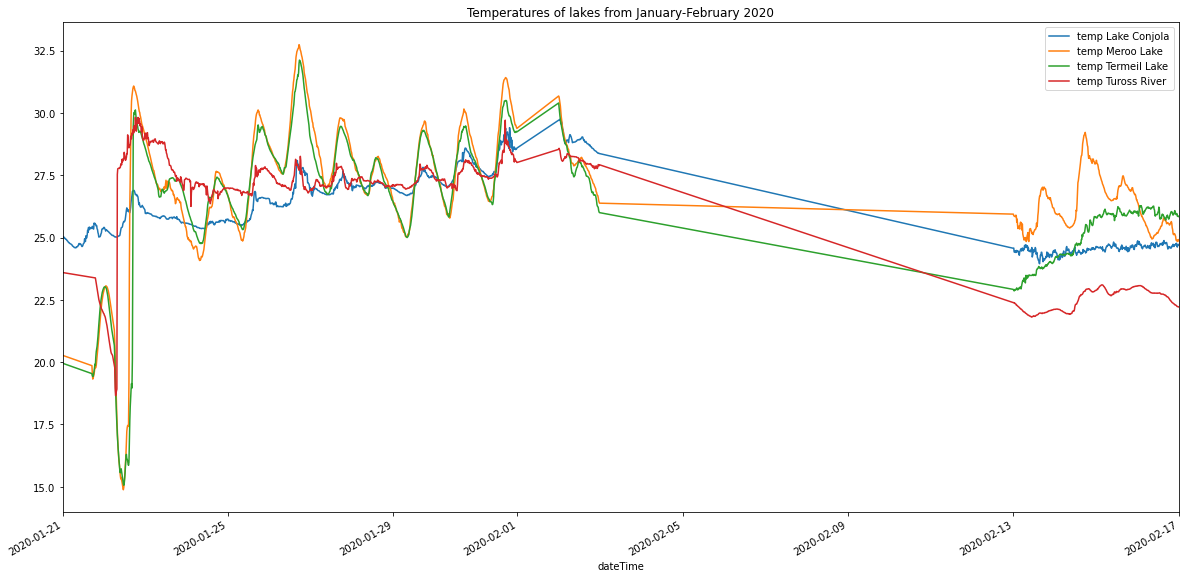

In [10]:
for name, df in all_lakes_df.groupby("estuaryName"):
    print(name, df.shape)
    df.set_index("dateTime").temp.plot(label=f"temp {name}")
plt.legend()
plt.xlim(["2020-01-21", "2020-02-17"])
plt.title("Temperatures of lakes from January-February 2020")
plt.show()

Lake Conjola (2687, 9)
Meroo Lake (2581, 9)
Termeil Lake (2591, 9)
Tuross River (2643, 9)


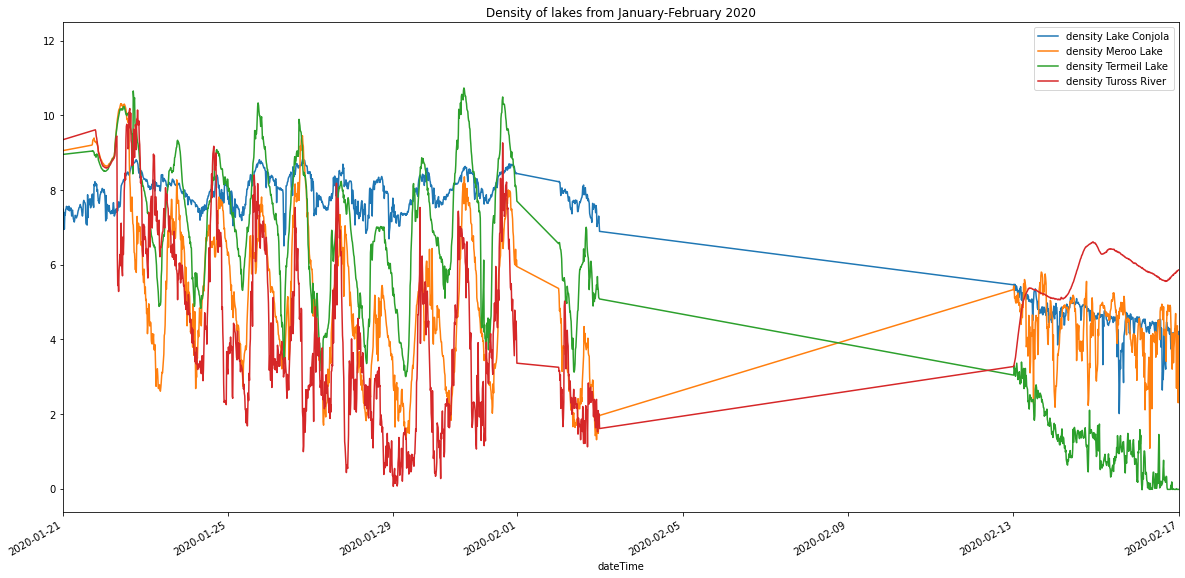

In [11]:
for name, df in all_lakes_df.groupby("estuaryName"):
    print(name, df.shape)
    df.set_index("dateTime").density.plot(label=f"density {name}")
plt.legend()
plt.xlim(["2020-01-21", "2020-02-17"])
plt.title("Density of lakes from January-February 2020")
plt.show()

Text(0.5, 1.0, 'Scatter plot of lakes temperature/density from January-February 2020')

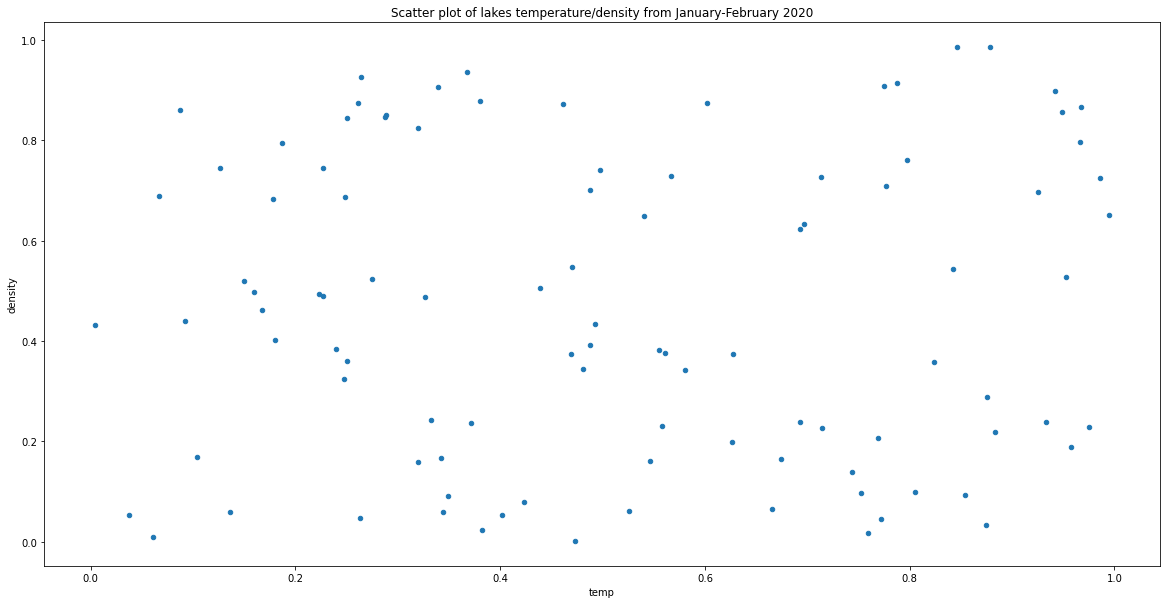

In [30]:
df = pd.DataFrame(np.random.rand(100, 2),
           columns =['temp', 'density'])
df.plot.scatter(x ='temp', y ='density');
plt.title("Scatter plot of lakes temperature/density from January-February 2020")

In [31]:
geolocator = Nominatim(timeout=10, user_agent = "myGeolocator")
location = geolocator.geocode('Lake Conjola')
print(location)
print((location.latitude, location.longitude))

Lake Conjola, Shoalhaven City Council, New South Wales, 2539, Australia
(-35.2698003, 150.4891222)


In [32]:
mapa = folium.Map(location=(-35.2698003, 150.4891222), zoom_start=12.4)
display(mapa)

In [33]:
geolocator = Nominatim(timeout=10, user_agent = "myGeolocator")
location = geolocator.geocode('Lake Termeil')
print(location)
print((location.latitude, location.longitude))

Termeil, Shoalhaven City Council, New South Wales, 2539, Australia
(-35.4816667, 150.3344444)


In [34]:
mapa = folium.Map(location=(-35.4816667, 150.3344444), zoom_start=13)
display(mapa)

In [35]:
geolocator = Nominatim(timeout=10, user_agent = "myGeolocator")
location = geolocator.geocode('Meroo Lake')
print(location)
print((location.latitude, location.longitude))

Meroo Lake, Bawley Point, Shoalhaven City Council, New South Wales, 2539, Australia
(-35.48396285, 150.3851423303642)


In [36]:
geolocator = Nominatim(timeout=10, user_agent = "myGeolocator")
location = geolocator.geocode('Tuross Lake')
print(location)
print((location.latitude, location.longitude))

Tuross Lake, Tuross Head, Eurobodalla Shire Council, New South Wales, 2537, Australia
(-36.054831899999996, 150.0992192774808)


In [37]:
location_1 = geolocator.geocode('Lake Conjola')
location_1_gps = (location_1.latitude, location_1.longitude)
location_2 = geolocator.geocode('Lake Termeil')
location_2_gps = (location_2.latitude, location_2.longitude)
# distance in kilometers
distance_calc_km = distance.distance(location_1_gps, location_2_gps).km
print(distance_calc_km)

27.387729943674273


In [38]:
location_1 = geolocator.geocode('Meroo Lake')
location_1_gps = (location_1.latitude, location_1.longitude)
location_2 = geolocator.geocode('Tuross Lake')
location_2_gps = (location_2.latitude, location_2.longitude)
# distance in kilometers
distance_calc_km = distance.distance(location_1_gps, location_2_gps).km
print(distance_calc_km)

68.41408199063747


In [39]:
df1 = pd.read_csv("lake_addresses_data/lake_addresses.csv")
df = df1.loc[:, ("Name", "City", "State", "Zip", "Longitude", "Latitude", "Type")]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       4 non-null      object 
 1   City       4 non-null      object 
 2   State      4 non-null      object 
 3   Zip        4 non-null      int64  
 4   Longitude  4 non-null      float64
 5   Latitude   4 non-null      float64
 6   Type       4 non-null      object 
dtypes: float64(2), int64(1), object(4)
memory usage: 352.0+ bytes


In [40]:
geometry = gpd.points_from_xy(df.Longitude, df.Latitude)
geo_df = gpd.GeoDataFrame(df[["Name", "City", "State", "Zip", "Longitude", "Latitude", "Type"]], geometry=geometry)

geo_df.head()

,Name,City,State,Zip,Longitude,Latitude,Type,geometry
0,Lake Termeil,Shoalhaven City Council,NSW,2539,-35.481667,150.334444,Lake,POINT (-35.482 150.334)
1,Lake Conjola,Shoalhaven City Council,NSW,2539,-35.269800,150.489122,Lake,POINT (-35.270 150.489)
2,Meroo Lake,Shoalhaven City Council,NSW,2539,-35.483963,150.385142,Lake,POINT (-35.484 150.385)
3,Tuross Lake,Eurobodalla Shire Council,NSW,2537,-36.054832,150.099219,Lake,POINT (-36.055 150.099)


In [41]:
# insert multiple markers, iterate through list
# add a different color marker associated with type of lake
map = folium.Map(location = [-35.2698003, 150.4891222], tiles ='OpenStreetMap' , zoom_start = 10)
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry ]

i = 0
for coordinates in geo_df_list:
    #assign a color marker for the type of lake
    if geo_df.Type[i] == "Lake Conjola":
        type_color = "green"
    elif geo_df.Type[i] == "Lake Termeil":
        type_color = "blue"
    elif geo_df.Type[i] == "Meroo Lake":
        type_color = "orange"
    elif geo_df.Type[i] == "Tuross Lake":
        type_color = "pink"
    else:
        type_color = "purple"

    #now place the markers with the popup labels and data
    map.add_child(folium.Marker(location = coordinates,
                            popup =
                            "Name: " + str(geo_df.Name[i]) + '<br>' +
                            "City: " + str(geo_df.City[i]) + '<br>' +
                            "State: " + str(geo_df.State[i]) + '<br>'
                            "Zip: " + str(geo_df.Zip[i]) + '<br>'
                            "Coordinates: " + str(geo_df_list[i]),
                            icon = folium.Icon(color = "%s" % type_color)))
    i = i + 1

In [42]:
map